![logo](https://github.com/donatellacea/DL_tutorials/blob/main/notebooks/figures/1128-191-max.png?raw=true)

# XAI in Deep Learning-Based Signal Analysis: Attention Maps for Text

In this Notebook, we will show how to produce attention maps for textual data. 
--------

## Getting Started

### Setup Colab environment

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section.
Otherwise, you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own.

<a href="https://colab.research.google.com/github/HelmholtzAI-Consultants-Munich/Zero2Hero---Introduction-to-XAI/blob/Juelich-2023/xai-model-for-1d-data/Tutorial_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Now that you opened the notebook in Colab, follow the next step:

1. Run this cell to connect your Google Drive to Colab and install packages
2. Allow this notebook to access your Google Drive files. Click on 'Yes', and select your account.
3. "Google Drive for desktop wants to access your Google Account". Click on 'Allow'.
   
At this point, a folder has been created in your Drive and you can navigate it through the lefthand panel in Colab, you might also have received an email that informs you about the access on your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive
!git clone --branch Juelich-2023 https://github.com/HelmholtzAI-Consultants-Munich/XAI-Tutorials.git
%cd XAI-Tutorials/xai-model-for-1d-data
# TODO: install packages not already present in Colab, e.g. %pip install lime

### Imports, data and model loading

In [41]:
%matplotlib inline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import torch

In [70]:
models_path = "../data_and_models/weights/t5_small"

In [71]:
def showAttention(input_sentence, output_words, attentions):
    fig, ax = plt.subplots(figsize=(20,5))
    cax = ax.matshow(attentions.detach().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([" "] + input_sentence, rotation=90)
    ax.set_yticklabels([" "] + output_words)
    # ax.set_yticklabels([''] + output_words)
    # Show label at every tick

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


We have fine-tuned a sequence to sequence model using the huggingface library for translation from english to french. Let's load our fine-tuned model as well as our tokenizer. 

In [72]:
model = AutoModelForSeq2SeqLM.from_pretrained(models_path)
tokenizer = AutoTokenizer.from_pretrained(models_path)

Now let's translate a sentence from english to french: 

In [60]:
text = "translate from English to French: I want to eat a big pizza with cheese."

Let's generate the tokens for the input

In [61]:
inputs = tokenizer(text, return_tensors="pt")
inputs

{'input_ids': tensor([[13959,    45,  1566,    12,  2379,    10,    27,   241,    12,     3,
          1544,     3,     9,   600,  6871,    28,  3285,     5,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

The `input` variable is a dictionary containing two keys, input_ids and attention_mask. input_ids contains two rows of integers (one for each sentence) that are the unique identifiers of the tokens in each sentence. We’ll explain what the attention_mask is later in this chapter.

We generate the corresponding french translation of our english sentence. We can then generate the self attention of the encoder, decoder and cross attention.

In [62]:
output = model.generate(inputs.input_ids, max_new_tokens=40, do_sample=True, top_k=30, top_p=0.95)
attention = model(**inputs, labels=output, output_attentions=True)

cross_attention = attention.cross_attentions
encoder_attention = attention.encoder_attentions
decoder_attention = attention.decoder_attentions

We can decode the input_ids of the input and output to generate their corresponding tokens 

In [63]:
decoded_input = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
decoded_input

['▁translate',
 '▁from',
 '▁English',
 '▁to',
 '▁French',
 ':',
 '▁I',
 '▁want',
 '▁to',
 '▁',
 'eat',
 '▁',
 'a',
 '▁big',
 '▁pizza',
 '▁with',
 '▁cheese',
 '.',
 '</s>']

In [64]:
decoded_output = tokenizer.convert_ids_to_tokens(output[0])
decoded_output

['<pad>',
 '▁Je',
 '▁',
 'veux',
 '▁manger',
 '▁une',
 '▁grande',
 '▁pizza',
 '▁',
 'à',
 '▁from',
 'age',
 '.',
 '</s>']

We average the heads of the last attention layer of the model and plot it

/tmp/ipykernel_21012/1982978113.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([" "] + input_sentence, rotation=90)
/tmp/ipykernel_21012/1982978113.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([" "] + output_words)


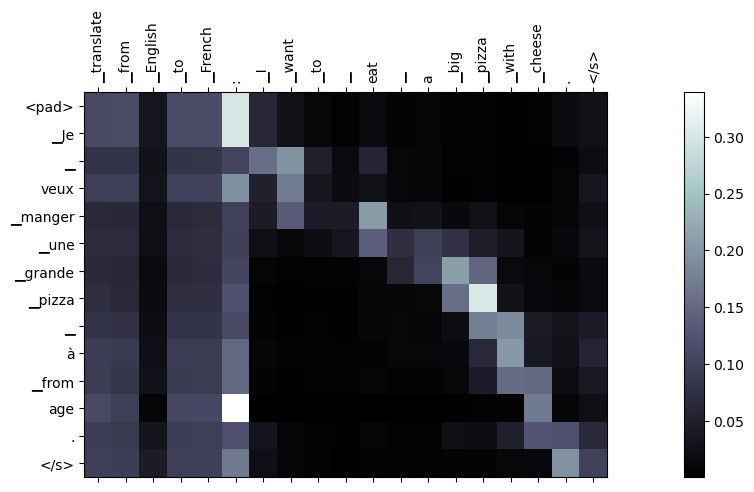

In [65]:
avg_attention = torch.stack(cross_attention).mean(0).mean(1).squeeze(0)
showAttention(decoded_input, decoded_output, avg_attention)

In [66]:
encoder_attention[0].shape

torch.Size([1, 8, 19, 19])

/tmp/ipykernel_21012/1982978113.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([" "] + input_sentence, rotation=90)
/tmp/ipykernel_21012/1982978113.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([" "] + output_words)


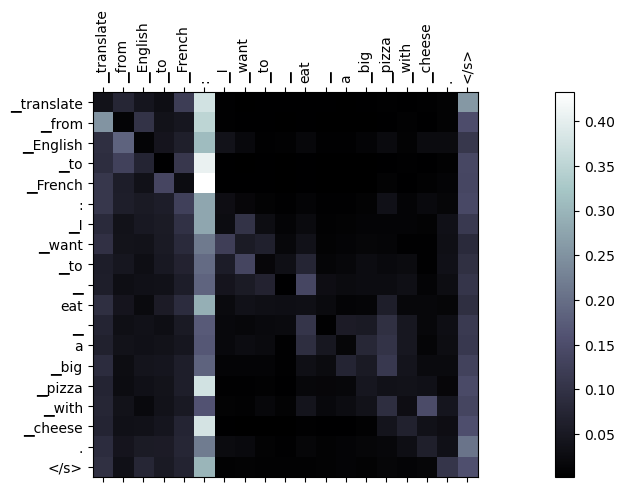

In [67]:
avg_encoder_attention = torch.stack(encoder_attention).mean(0).mean(1).squeeze(0)
showAttention(decoded_input, decoded_input, avg_encoder_attention)

/tmp/ipykernel_21012/1982978113.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([" "] + input_sentence, rotation=90)
/tmp/ipykernel_21012/1982978113.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([" "] + output_words)


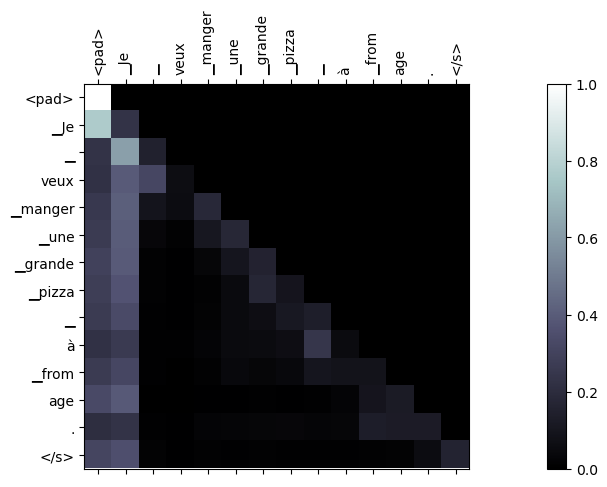

In [68]:
avg_decoder_attention = torch.stack(decoder_attention).mean(0).mean(1).squeeze(0)
showAttention(decoded_output, decoded_output, avg_decoder_attention)

What Does it Mean

How Does it Work